# Face detection and BMI/Age/Sex prediction

The model provides end-to-end capability of detecting faces and predicting the BMI, Age and Gender for each person. 

The architecture of the model is described as below:

![](./img/model_structure.jpg)


## Face detection

Face detection is done by `MTCNN`, which is able to detect multiple faces within an image and draw the bounding box for each faces.  

It serves two purposes for this project:

### 1) preprocess and align the facial features of image.

Prior model training, each image is preprocessed by `MTCNN` to extract faces and crop images to focus on the facial part. The cropped images are saved and used to train the model in later part.

Illustration of face alignment:
![](./img/mtcnn_face_alignment.jpg)

### 2) enable prediction for multiple persons in the same image.

In inference phase, faces will be detected from the input image. For each face, it will go through the same preprocssing and make the predictions.

Illustration of ability to predict for multiple faces:
![](./img/detect_predict_multi_faces.png)

## Multi-task prediction

In vanilla CNN architecture, convolution blocks are followed by the dense layers to make output the prediction. In a naive implementation, we can build 3 models to predict BMI, age and gender individually. However, there is a strong drawback that 3 models are required to be trained and serialized separately, which drastically increases the maintenance efforts.

|   |
|---|
|`[input image] => [VGG16] => [dense layers] => [BMI]`|
|`[input image] => [VGG16] => [dense layers] => [AGE]`|
|`[input image] => [VGG16] => [dense layers] => [SEX]`|

Since we are going to predict `BMI`, `Age`, `Sex` from the same image, we can share the same backbone for the three different prediction heads and hence only one model will be maintained.

|    |
|----|
|`[input image] => [VGG16] => [separate dense layers] x3 => weighted([BMI], [AGE], [SEX])`|

This is the most simplified multi-task learning structure, which assumed independent tasks and hence separate dense layers were used for each head. Other research such as `Deep Relationship Networks`, used `matrix priors` to model the relationship between tasks.

![](https://ruder.io/content/images/2017/05/relationship_networks.png)
_A Deep Relationship Network with shared convolutional and task-specific fully connected layers with matrix priors (Long and Wang, 2015)._
 
## Reference
 * MTCNN: [https://github.com/ipazc/mtcnn](https://github.com/ipazc/mtcnn)
 * VGGFace: [https://github.com/rcmalli/keras-vggface](https://github.com/rcmalli/keras-vggface)

In [9]:
mode = 'train' #'train' or 'predict'
model_type = 'vgg16'
model_tag = 'base'
model_id = '{:s}_{:s}'.format(model_type, model_tag)
model_dir = './saved_model/model_{:s}.h5'.format(model_id)
bs = 8
epochs = 2
freeze_backbone = True # True => transfer learning; False => train from scratch

In [10]:
import pandas as pd
import os
import json
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from scripts.models import FacePrediction
import glob

allimages = os.listdir('./data/face_aligned/')
train = pd.read_csv('./data/train.csv')
valid = pd.read_csv('./data/valid.csv')

train = train.loc[train['index'].isin(allimages)]
valid = valid.loc[valid['index'].isin(allimages)]

In [11]:
# create metrics, model dirs
Path('./metrics').mkdir(parents = True, exist_ok = True)
Path('./saved_model').mkdir(parents = True, exist_ok = True)

## Data

This is fairly small dataset, which comprises 1530 records and  16 columns.

* sex imbalance: 80% of the data is male
* age is near truncated normal distribution. min Age is 18, average Age is 34.
* race is dominated by Black and White. Asian samples are very limited.
* BMI is normal distrbuted, with mean at 26.

* no obvious correlation found between BMI and Age, Sex.

In [12]:
data = pd.concat([train, valid])
data[['age','race','sex','bmi','index']].head()

age   race   sex        bmi       index
0   54  Black  Male  39.051641  248038.jpg
1   26  Black  Male  29.288731  250464.jpg
2   21  Black  Male  23.028211  270020.jpg
3   29  White  Male  29.529925  277774.jpg
4   18  White  Male  19.005974  279426.jpg

/Users/amandachau/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


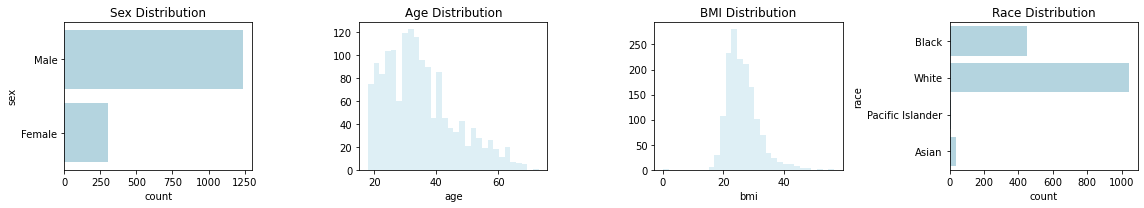

In [13]:
color = 'lightblue'
fig, axs = plt.subplots(1,4)
fig.set_size_inches((16, 3))
sns.countplot(y = data.sex, color = color, ax = axs[0])
axs[0].set_title('Sex Distribution')
sns.distplot(data.age,  bins = 30, kde=False, color=color, ax = axs[1])
axs[1].set_title('Age Distribution')
sns.distplot(data.bmi,  bins = 30, kde=False, color=color, ax = axs[2])
axs[2].set_title('BMI Distribution')
sns.countplot(y = data.race, color = color, ax = axs[3])
axs[3].set_title('Race Distribution')
plt.tight_layout()

In [14]:
def sns_hist(data, x, hue, ax = None, title = 'title', xlabel = None, **kwargs):
    
    xlabel = x.upper() if xlabel == None else xlabel
    
    group = data[hue].unique()
    for g in group:
        sns.distplot(data.loc[data[hue] == g, x], label = g, ax = ax,  **kwargs)
    if ax == None:
        plt.legend()
        plt.title(title)
        plt.xlabel(xlabel)
    else:
        ax.legend()
        ax.set_title(title)
        ax.set_xlabel(xlabel)
    return ax

/Users/amandachau/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/amandachau/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/amandachau/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

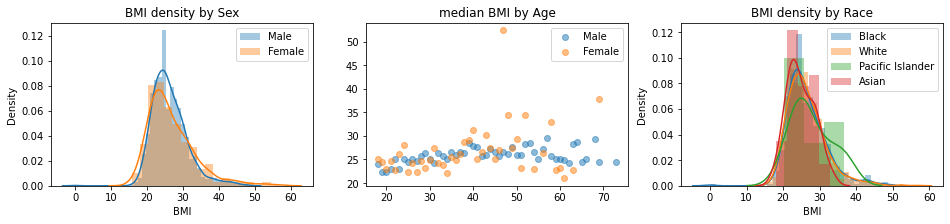

In [15]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches((16, 3))

sns_hist(data, x = 'bmi', hue = 'sex', ax = axs[0], title = 'BMI density by Sex', kde = True)

res = data.groupby(['age','sex'], as_index=False)['bmi'].median()
for i in ['Male','Female']:
    axs[1].scatter(res.loc[res.sex == i,'age'].values, res.loc[res.sex == i,'bmi'].values,label = i, alpha = 0.5)
axs[1].set_title('median BMI by Age')
axs[1].legend()

sns_hist(data, x = 'bmi', hue = 'race', ax = axs[2], title = 'BMI density by Race', kde = True)

plt.show()

## Training

In [16]:
es = EarlyStopping(patience=3)
ckp = ModelCheckpoint(model_dir, save_best_only=True, save_weights_only=True, verbose=1)
tb = TensorBoard('./tb/%s'%(model_id))
callbacks = [es, ckp]

model = FacePrediction(img_dir = './data/face_aligned/', model_type = model_type)
model.define_model(freeze_backbone = freeze_backbone)
model.model.summary()
if mode == 'train':
    model_history = model.train(train, valid, bs = bs, epochs = epochs, callbacks = callbacks)
else:
    model.load_weights(model_dir)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 224, 224, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 224, 224, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 112, 112, 64) 0           conv1_2[0][0]                    
____________________________________________________________________________________________

/Users/amandachau/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


152/152 [==============================] - 231s 2s/step - loss: 22.1323 - bmi_loss: 23.4829 - age_loss: 33.1388 - sex_loss: 0.3212 - sex_accuracy: 0.8746 - val_loss: 12.5060 - val_bmi_loss: 12.8847 - val_age_loss: 21.8767 - val_sex_loss: 0.1062 - val_sex_accuracy: 0.9688

Epoch 00001: val_loss improved from inf to 12.50604, saving model to ./saved_model/model_vgg16_base.h5
Epoch 2/2
152/152 [==============================] - 251s 2s/step - loss: 10.8999 - bmi_loss: 11.0647 - age_loss: 20.3635 - sex_loss: 0.1182 - sex_accuracy: 0.9533 - val_loss: 5.0703 - val_bmi_loss: 5.2971 - val_age_loss: 8.2867 - val_sex_loss: 0.0398 - val_sex_accuracy: 0.9875

Epoch 00002: val_loss improved from 12.50604 to 5.07032, saving model to ./saved_model/model_vgg16_base.h5


## Evaluations

![](./img/tensorboard_results.png)

| Model | BMI (RMSE) | Age (RMSE) | Sex (AUC) |
|-------|------------|------------|-----------|
|vgg16  |4.56|5.66|0.99|
|vgg16_fc6| 4.99 | 6.04 | 0.99 |
|resnet50|5.21 | 7.02 | 0.99|

In [17]:
valid['gender'] = valid.sex.map(lambda i: 1 if i == 'Male' else 0)

In [18]:
metrics = model.evaulate(valid)
metrics['model'] = model_type
with open('./metrics/{:s}.json'.format(model_type), 'w') as f:
    json.dump(metrics, f)

metrics = []
for i in glob.glob('./metrics/*.json'):
    with open(i, 'r') as f:
        res = json.load(f)
    metrics.append(res)
metrics = pd.DataFrame(metrics)
metrics['model'] = metrics['model'].apply(lambda i: '* ' + i if i == model_id else i)
metrics.set_index('model').round(3)

bmi_mae  bmi_cor  age_mae  sex_auc
model                                          
vgg16_seqMT    5.577    0.179    8.794    0.999
vgg16          5.830    0.194    8.399    0.999

## Predictions

### predict from a single image

In [19]:
model.predict('./data/test/test_aligned/trump.jpg')

[array([[24.765676]], dtype=float32),
 array([[74.2365]], dtype=float32),
 array([[0.6591773]], dtype=float32)]

### predict from a directory

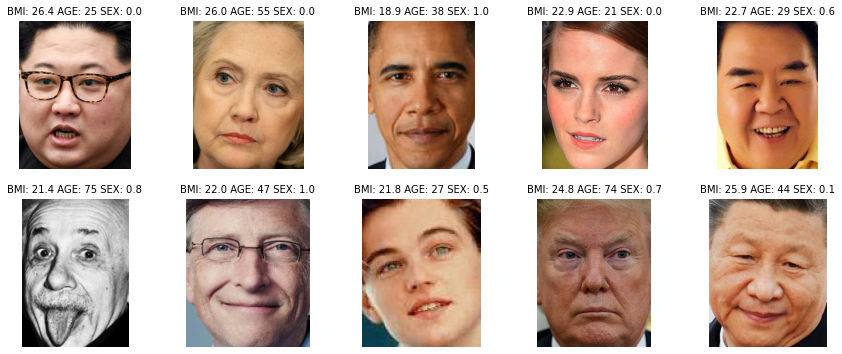

In [20]:
preds = model.predict('./data/test/test_aligned/', show_img = True)

In [21]:
model.predict_df('./data/test/test_aligned')

img        bmi        age     sex  sex_prob
0      Kim Jong-un.jpg  26.416132  25.367203  Female  0.000742
1   hilary_clinton.jpg  25.966330  55.342991  Female  0.000090
2     barack-obama.jpg  18.897913  37.539074    Male  0.990909
3      emma_watson.jpg  22.901377  20.983862  Female  0.002165
4       kent_zheng.jpg  22.731407  28.633396    Male  0.600760
5  albert-einstein.jpg  21.397936  75.414581    Male  0.772974
6       bill-gates.jpg  21.965818  47.267300    Male  0.985786
7        leonardo.jpeg  21.825254  27.304964    Male  0.548587
8            trump.jpg  24.765676  74.236496    Male  0.659177
9               xi.jpg  25.857533  44.311138    Male  0.089188

### predict multiple faces

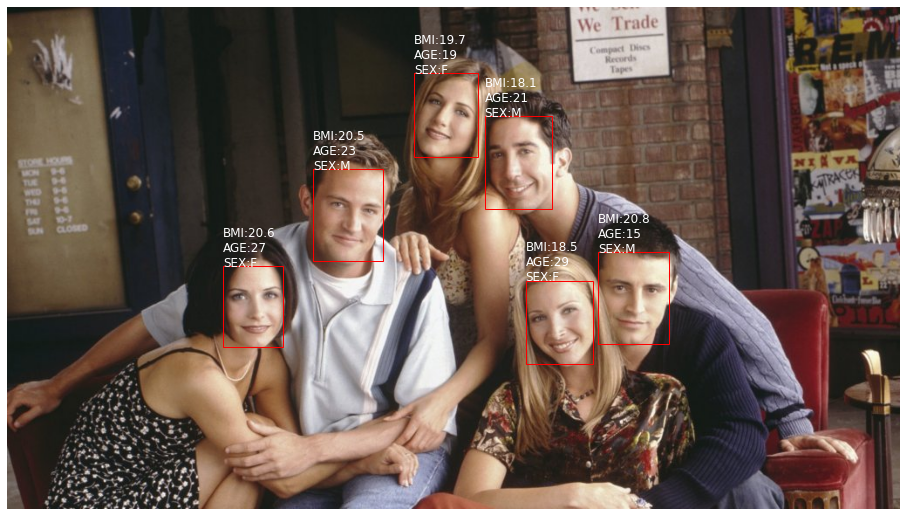

In [22]:
preds = model.predict_faces('./data/test/multi_face/friends.jpg', color = 'white')

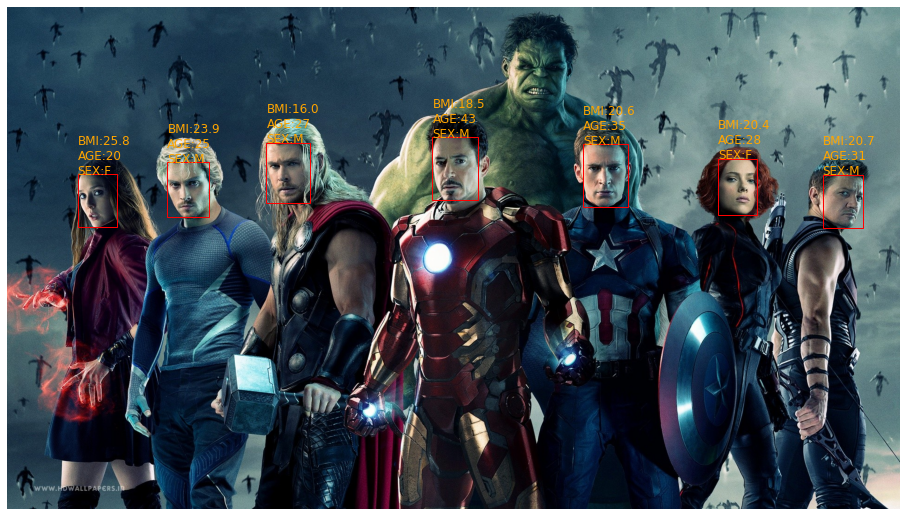

In [23]:
preds = model.predict_faces('./data/test/multi_face/avengers.jpg', color = 'orange')

### With League Data

Cleave_2021_Summer.png


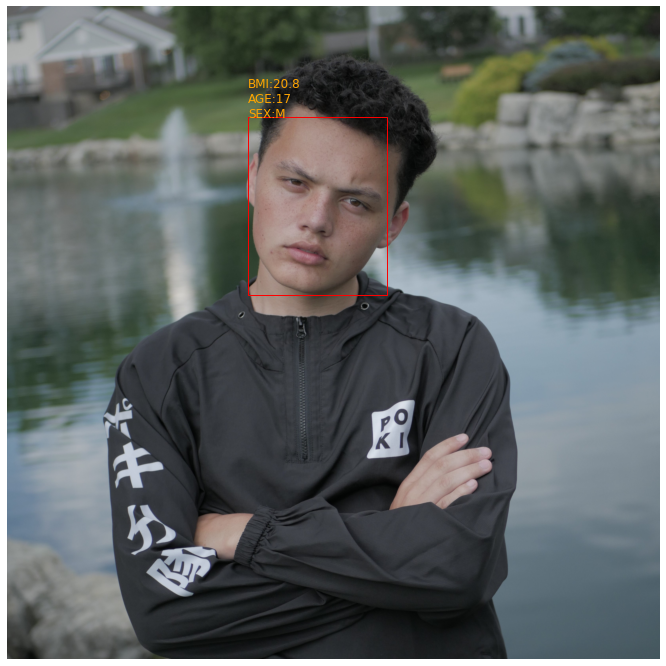

Darshan_2022_Spring.png


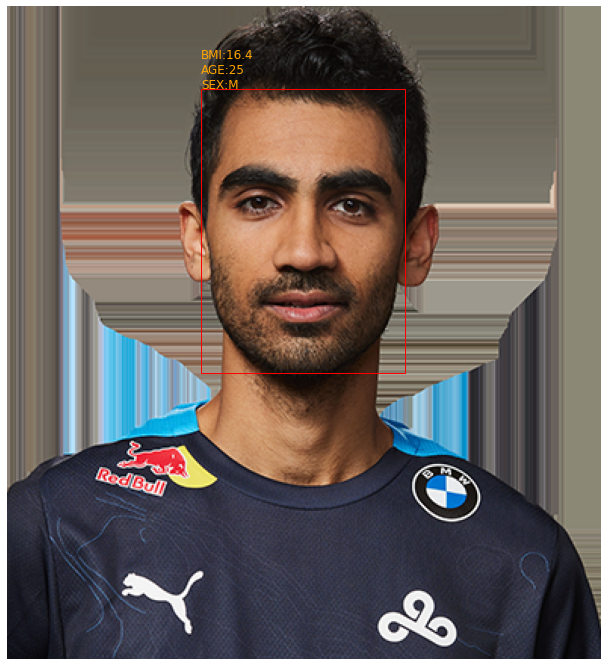

Darshan_2018_Spring.png


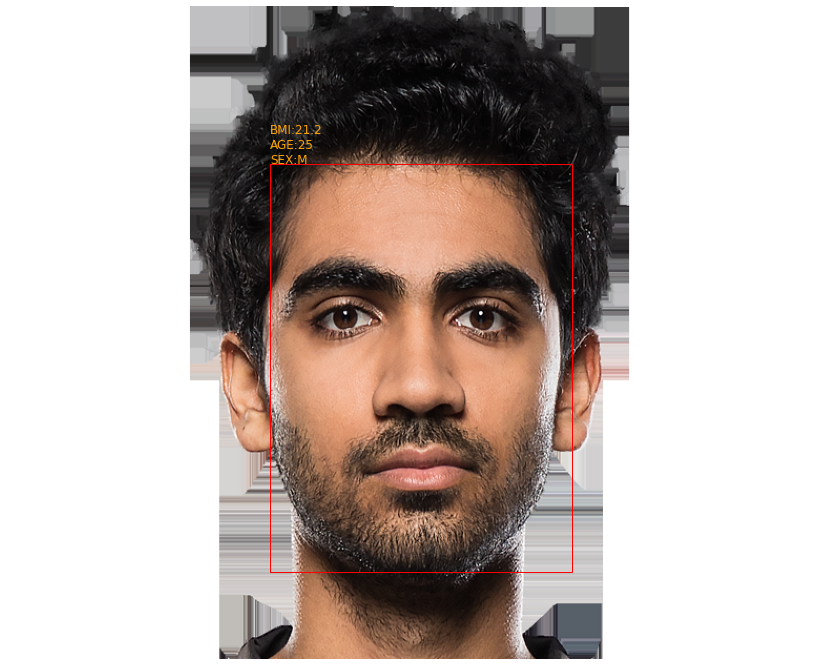

Darshan_2022_Summer.png


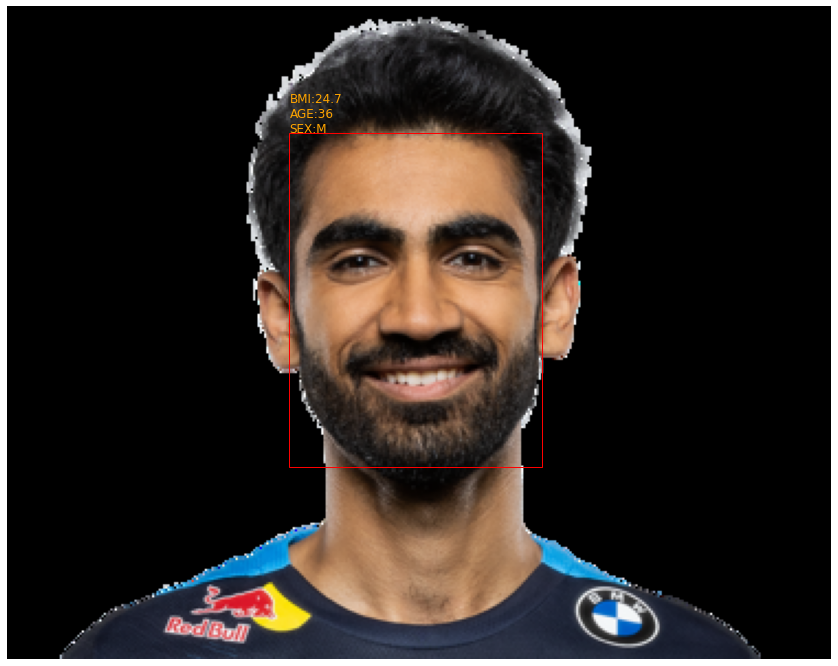

Cleave_2021_Spring.png
Skipping image: ./data/test/bmi_test/Cleave_2021_Spring.png (corrupt or unsupported format)
Darshan_2018_Summer.png


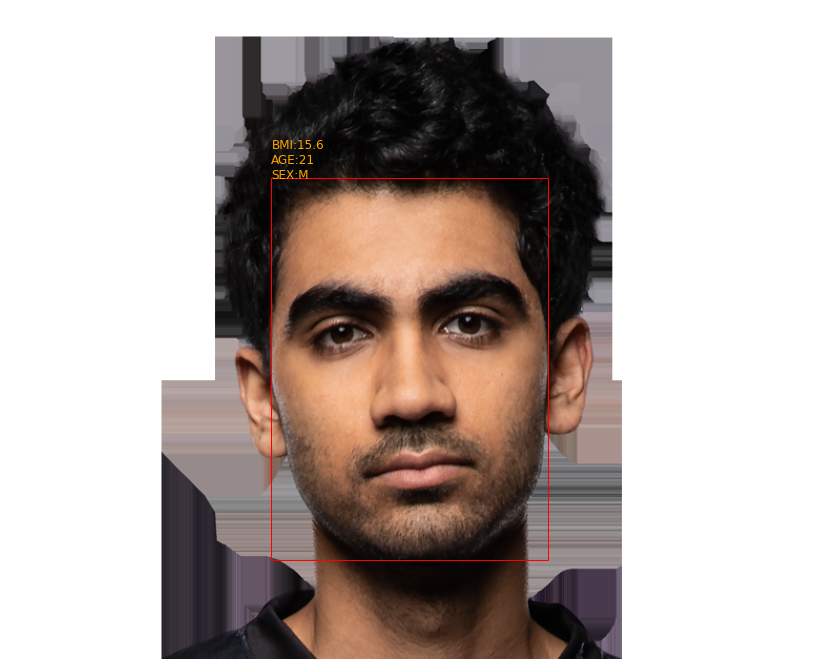

Darshan_2017_Spring.png


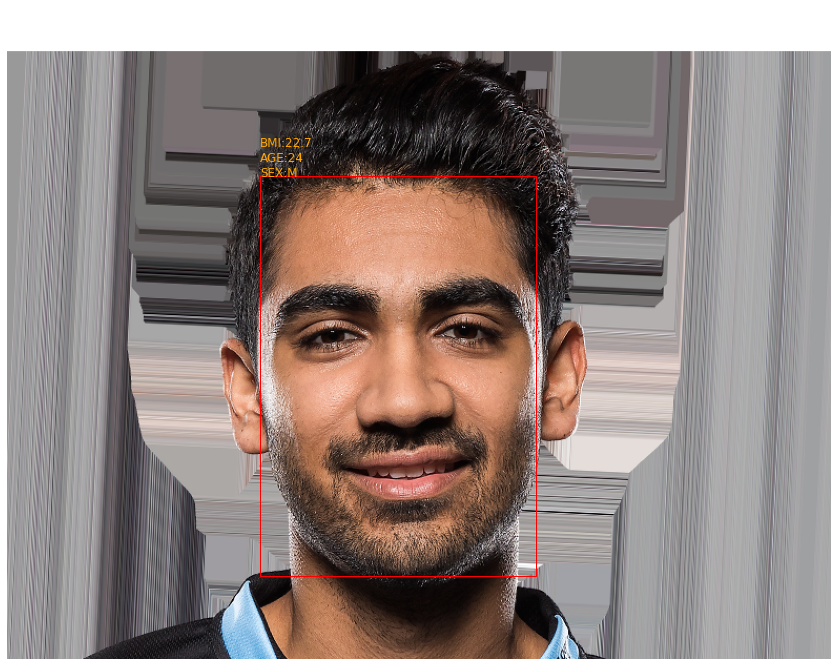

Darshan_2019_Spring.png


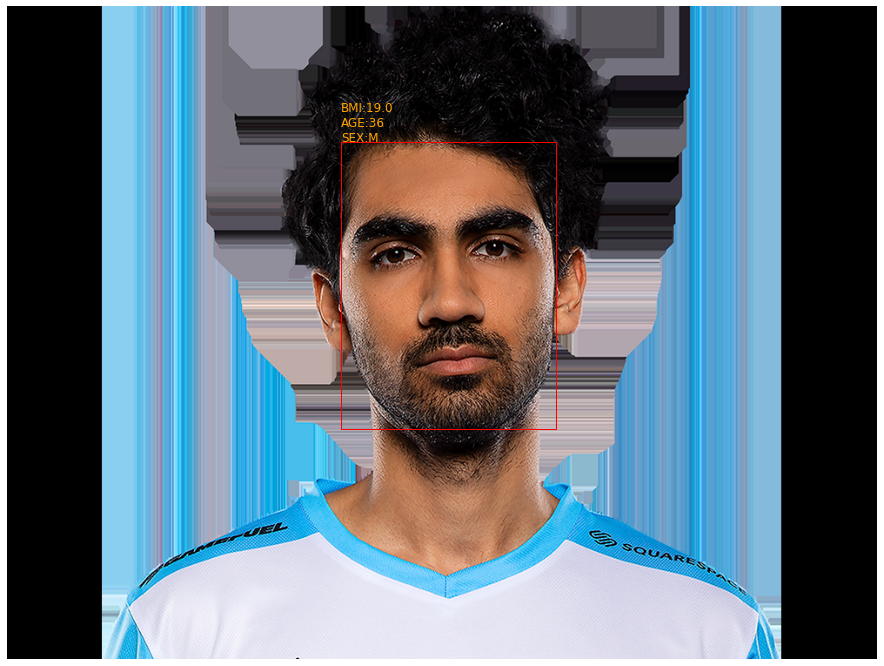

Darshan_2016_Summer.png


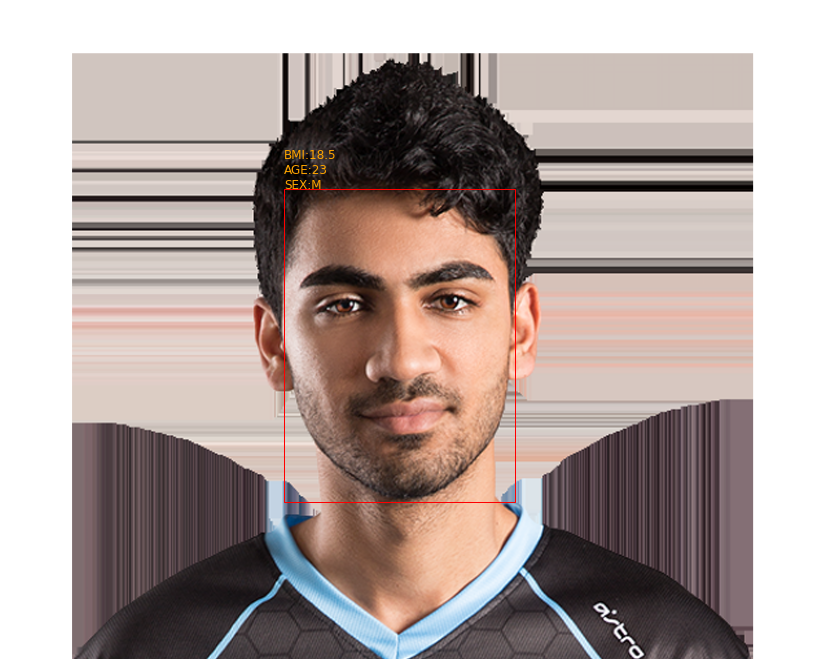

Darshan_2021_Spring.png


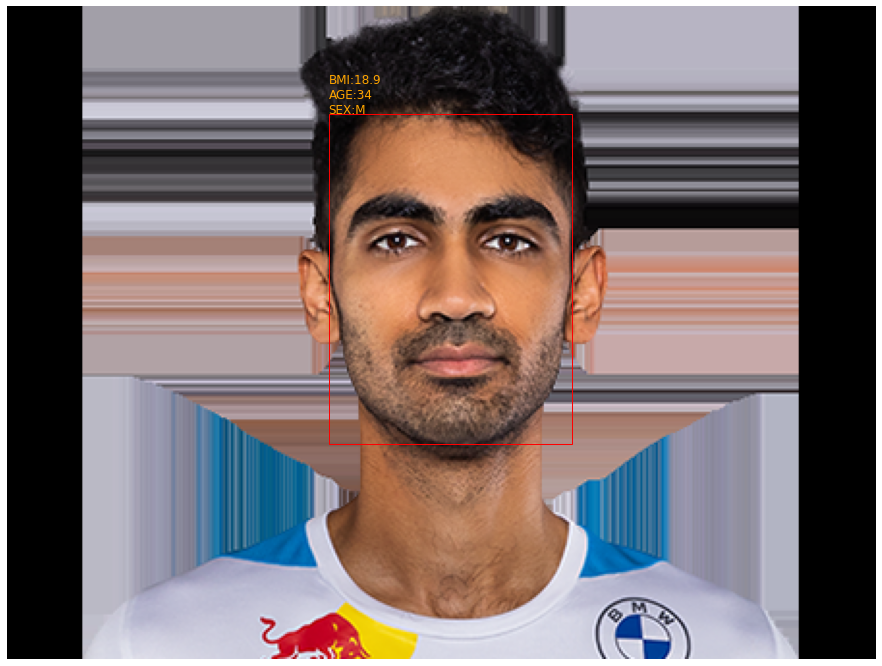

Darshan_2016_Spring.png


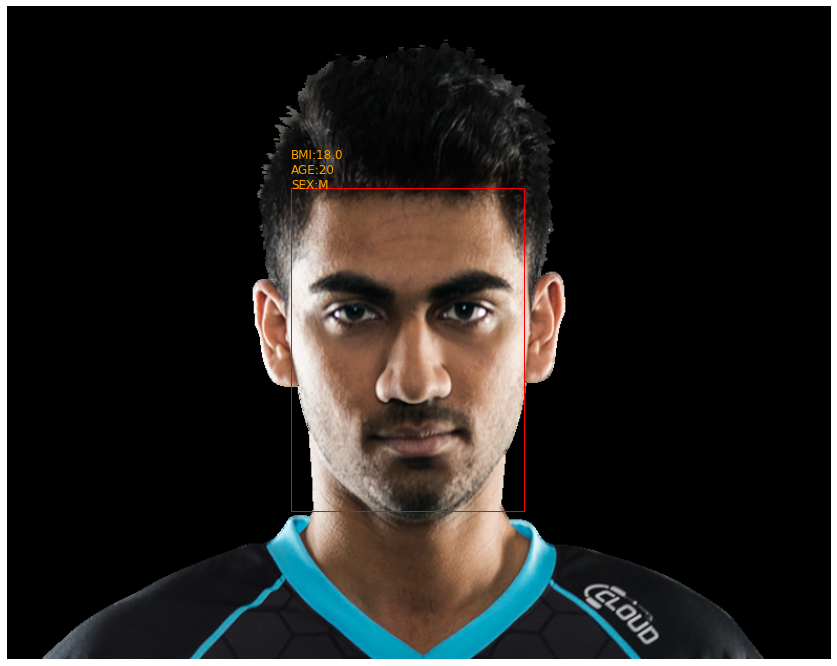

Darshan_2016_Summer_2.png


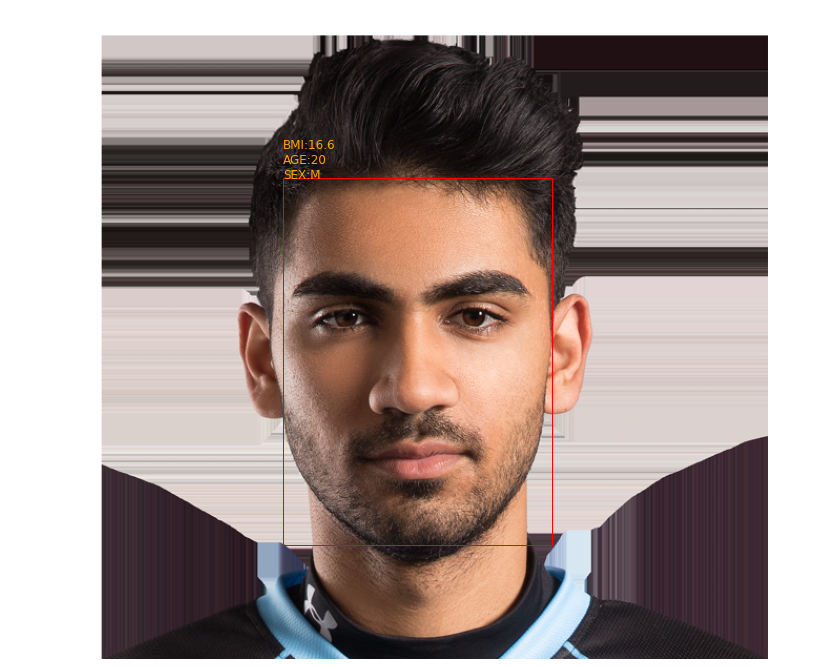

In [51]:
from PIL import Image

directory = './data/test/bmi_test/'
for item in os.listdir(directory):
    print(item)
    item_path = os.path.join(directory, item)
    try:
        image = Image.open(item_path)
        model.predict_faces(item_path, color='orange')
    except Image.UnidentifiedImageError:
        print(f"Skipping image: {item_path} (corrupt or unsupported format)")
        continue